In [1]:
# @title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here", "setup.py"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    os.system("pip install objax chex tfds-nightly tf-nightly einops")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

### Package Preamble

In [2]:
# jax packages
import jax
import jax.numpy as jnp
from jax.config import config
import chex

config.update("jax_enable_x64", False)

# datasets
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from functools import partial
from sklearn.preprocessing import StandardScaler

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext lab_black
%matplotlib inline
%load_ext autoreload
%autoreload 2

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Data

We're going to using the MNIST dataset. It's a simple dataset with a single channel image and `28x28`. So overall it's `60Kx28x28x1`.

We're going to use the `numpy` standard for the images.

`B,H,W,C`

where:
* `B` - batch size
* `H` - height 
* `W` - width
* `C` - channels


## Full Example

### Data

In [148]:
# normalize images
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

In [149]:
# DATA, CIFAR10
ds, ds_info = tfds.load(
    "cifar10", split="train", as_supervised=True, shuffle_files=True, with_info=True
)


ds = ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# take some examples
B = 10_000

# take 10 samples from the dataset
ds_sample = ds.take(B)

In [150]:
# extract all images
X = [x[0] for x in tfds.as_numpy(ds_sample)]

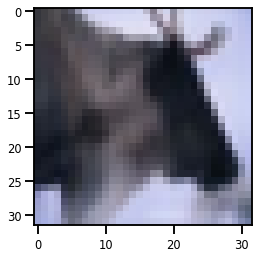

In [151]:
plt.imshow(X[0])

In [152]:
# stack them in a new batch axes
X = np.stack(X).astype(np.float32)

print(X[0].min(), X[0].max())

# add some noise
X += 0.001 * np.random.rand(*X.shape)
X.shape

0.039215688 0.96862745


(10000, 32, 32, 3)

In [153]:
# normalize
from sklearn.preprocessing import StandardScaler

X = X.reshape(-1, 1)

x_scaler = StandardScaler()
X = x_scaler.fit_transform(X)

X = X.reshape((B, 32, 32, 3))

# convert to jax array
X = jnp.array(X)

X.shape

(10000, 32, 32, 3)

In [154]:
def rescale_image(img, scaler):
    H, W, C = img.shape

    img = img.reshape((1, H * W * C))

    img = scaler.inverse_transform(img)

    img = img.reshape((H, W, C))
    return img

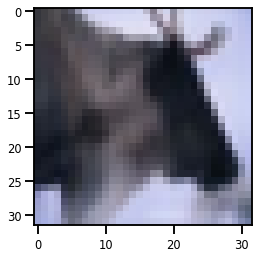

In [155]:
plt.imshow(rescale_image(X[0], x_scaler))

<ipython-input-156-a69cf7dab745>:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


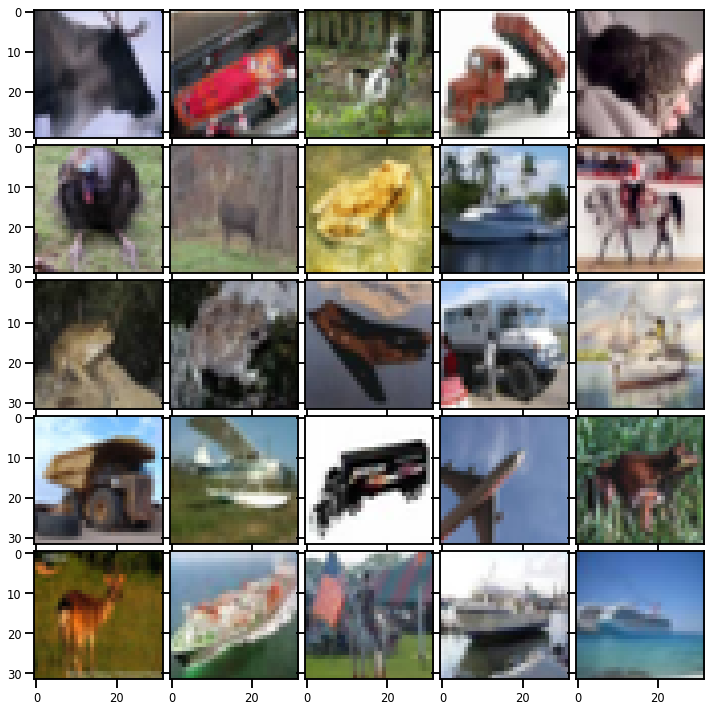

In [156]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10.0, 10.0))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(5, 5),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for i, ax in enumerate(grid):
    img = rescale_image(X[i], x_scaler)

    ax.imshow(img)

plt.tight_layout()
plt.show()

## Model

#### Layer 0 - Collapsing Dimensions

In [157]:
from rbig_jax.transforms.reshape import InitCollapseLayer
from rbig_jax.transforms.base import InverseBijector

In [158]:
# create init function
init_ravel_f = InitCollapseLayer("features")

# initialize layer
sq_layer = init_ravel_f((), shape=(32, 32, 3))

# forward transform
X_t = sq_layer.forward(X[:10])
X_t.shape

(10, 3072)

In [159]:
# gradient transform
X_t_ldj = sq_layer.forward_log_det_jacobian(X[:10])
X_t_ldj.shape

(10, 1)

In [160]:
# inverse transform
X_a = sq_layer.inverse(X_t)
X_a.shape

chex.assert_tree_all_close(X_a, X[:10])

In [161]:
# isq_layer = Inverse(init_ravel_f((), shape=(32, 32, 3)))

In [162]:
isq_layer = InverseBijector(bijector=sq_layer)

# forward transform
X_a = isq_layer.forward(X_t)
print(X_a.shape)

# inverse transform
X_t_ = isq_layer.inverse(X_a)
print(X_t_.shape)

(10, 32, 32, 3)
(10, 3072)


In [99]:
isq_layer

InverseBijector(bijector=<rbig_jax.transforms.reshape.CollapseLayer object at 0x7fde801657f0>)

In [163]:
from rbig_jax.transforms.reshape import InitSqueezeLayer

In [53]:
init_sq_f = InitSqueezeLayer((2, 2))

In [54]:
sq_layer = init_sq_f((), shape=(32, 32, 3))

In [55]:
X_t = sq_layer.forward(X[:10])
X_t.shape

(10, 2, 2, 768)

In [56]:
X_t_ldj = sq_layer.forward_log_det_jacobian(X[:10])
X_t_ldj.shape

(10, 32, 32, 3)

In [57]:
f = jax.jit(init_sq_f)

In [61]:
%%time

_ = f((), shape=(32, 32, 3))

CPU times: user 594 µs, sys: 0 ns, total: 594 µs
Wall time: 242 µs


#### Layer I - Mixture Logistic CDF

In [164]:
from rbig_jax.transforms.parametric.mixture.logistic import InitMixtureLogisticCDF

In [165]:
# spline parameters
n_components = 20
n_features = 768
key = jax.random.PRNGKey(123)

init_mixcdf_f = InitMixtureLogisticCDF(n_components=n_components,)

#### Layer II - Logistic Transform

In [166]:
# Logit transform
from distrax._src.bijectors.sigmoid import Sigmoid
from distrax._src.bijectors.inverse import Inverse

#### Layer III - Convolutional Exponential

In [167]:
from rbig_jax.transforms.parametric.conv import InitConv1x1Householder

In [168]:
# Householder Transformation
n_reflections = 4
init_conv_func = InitConv1x1Householder(n_reflections=n_reflections)

# initialize the bijector
key = jax.random.PRNGKey(123)
key, hh_rng = jax.random.split(key, 2)

shape = X.shape[1:]
conv1x1_bijector = init_conv_func(hh_rng, shape)

In [169]:
from rbig_jax.transforms.base import BijectorChain

In [181]:
# create keys for all inits
n_layers = 5
shape = (32, 32, 3)
n_features = int(32 * 32 * 3)
bijectors = []

KEY = jax.random.PRNGKey(123)
rng, *layer_rngs = jax.random.split(KEY, num=n_layers)

# collapse layer
init_ravel_f = InitCollapseLayer("features")
sq_layer = init_ravel_f((), shape=shape)

data = sq_layer.forward(X)

# uncollapse layer
isq_layer = InverseBijector(bijector=sq_layer)

for irng in layer_rngs:

    mxdf_rng, rot_rng = jax.random.split(irng, 2)

    # nonlinear layer
    bijectors.append(init_mixcdf_f(mxdf_rng, n_features=n_features))

    # logistic layer
    bijectors.append(Inverse(Sigmoid()))

    # uncollapse dimensions
    bijectors.append(isq_layer)

    # linear layer
    bijectors.append(init_conv_func(rot_rng, shape=shape))

    # collapse dimensions
    bijectors.append(sq_layer)


# create chain
chain_bijectors = BijectorChain(bijectors=bijectors)

In [183]:
%%time

X_t = chain_bijectors.forward(data[:10])

X_t.shape

CPU times: user 726 ms, sys: 26.8 ms, total: 753 ms
Wall time: 477 ms


(10, 3072)

In [184]:
##

X_t = chain_bijectors.forward_log_det_jacobian(data[:10])

X_t.shape

(10, 1)

In [185]:
f = jax.jit(chain_bijectors.forward)

In [186]:
X_t = f(data[:10])

## Training

In [194]:
from rbig_jax.data import DensityDataset, collate_fn
import torch.multiprocessing as multiprocessing
from torch.utils.data import DataLoader

# multiprocessing.set_start_method("spawn")

# initialize dataset
ds = DensityDataset(np.array(data)[:1_000])

# initialize dataloader
batch_size = 128
shuffle = True

dl = DataLoader(
    ds, batch_size=batch_size, shuffle=shuffle, collate_fn=None, num_workers=0
)

In [195]:
import jax.numpy as jnp
from rbig_jax.training import init_log_prob
from rbig_jax.loss import init_nll_loss
from distrax._src.distributions.normal import Normal

# init base distribtion (Gaussian)
base_dist = Normal(0.0, 1.0)

# create log probability
log_prob = init_log_prob(base_dist)

# create loss function
nll_loss = init_nll_loss(log_prob)

In [196]:
from jax.experimental import optimizers
from rbig_jax.training import init_train_op, train_model


lr = 0.01
optimizer = optimizers.adam
jitted = True
epochs = 100

# initialize training procedure
train_op, opt_params = init_train_op(
    chain_bijectors, nll_loss, optimizer, lr=lr, jitted=jitted
)

In [197]:
# train model
final_bijector, losses = train_model(train_op, opt_params, dl, epochs=epochs,)

100%|██████████| 100/100 [12:39<00:00,  7.60s/it, loss=nan]       


In [26]:
X_t = conv1x1_bijector.forward(X[:25])

<ipython-input-27-ac649b7c79f6>:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


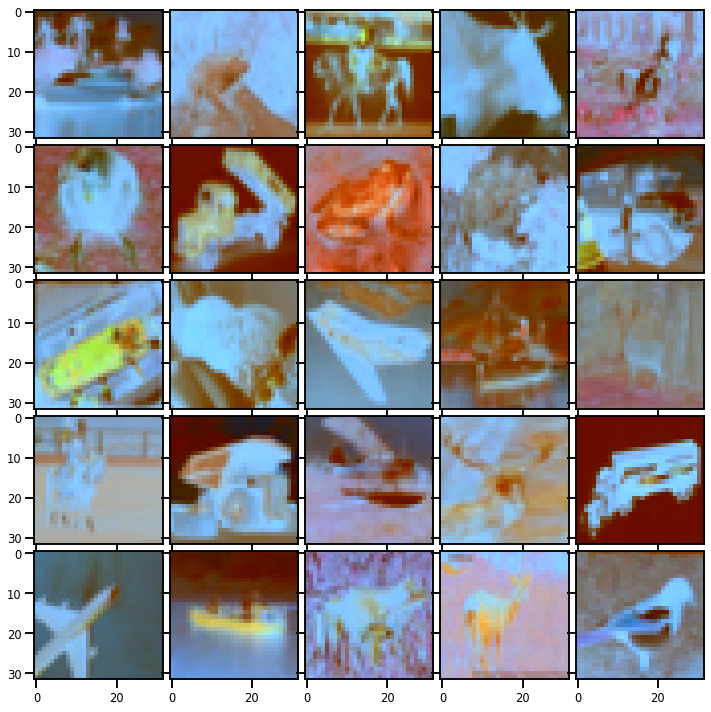

In [27]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10.0, 10.0))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(5, 5),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for i, ax in enumerate(grid):
    img = rescale_image(X_t[i], x_scaler)

    ax.imshow(img)

plt.tight_layout()
plt.show()

In [28]:
X_approx = conv1x1_bijector.inverse(X_t)

<ipython-input-29-6d9f298896fa>:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


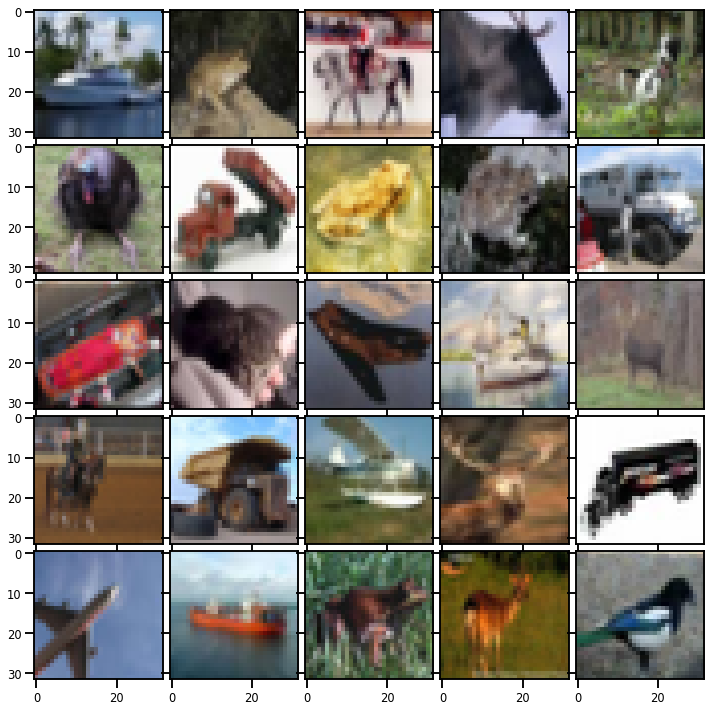

In [29]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10.0, 10.0))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(5, 5),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for i, ax in enumerate(grid):
    img = rescale_image(X_approx[i], x_scaler)

    ax.imshow(img)

plt.tight_layout()
plt.show()

### Model

In [60]:
from rbig_jax.transforms.rotation import InitPCARotation
from rbig_jax.transforms.histogram import InitUniHistUniformize
from rbig_jax.transforms.block import InitRBIGBlock
import corner
from rbig_jax.transforms.reshape import Squeeze

support_extension = 10
alpha = 1e-5
precision = 100
nbins = int(jnp.sqrt(X.shape[0]))


# initialize histogram transformation
uni_uniformize = InitUniHistUniformize(
    n_samples=X.shape[0],
    nbins=nbins,
    support_extension=support_extension,
    precision=precision,
    alpha=alpha,
)

# initialize rotation transformation
rot_transform = InitPCARotation()

# initialize marginal gaussianization
eps = 1e-5

fit_transform_func, forward_f, grad_f, inverse_f = InitRBIGBlock(
    uni_uniformize, rot_transform, eps
)

# optional, compiles the function to make it faster
fit_transform_func_jitted = jax.jit(fit_transform_func)
forward_f_jitted = jax.jit(forward_f)
grad_f_jitted = jax.jit(grad_f)
inverse_f_jitted = jax.jit(inverse_f)

### Model Training

In [61]:
# initialize layer
reshape_layer = Squeeze((2, 2), None)

# initialize params and functions
_, f, inv_f = reshape_layer((), X.shape)

#
# transform data
X_t, _ = f((), X)

X_t.shape

(50000, 768, 2, 2)

Multiscale Level: 5, Filter: (32, 32), Size: (150_000,1_024): 100%|██████████| 5/5 [12:12<00:00, 146.51s/it]


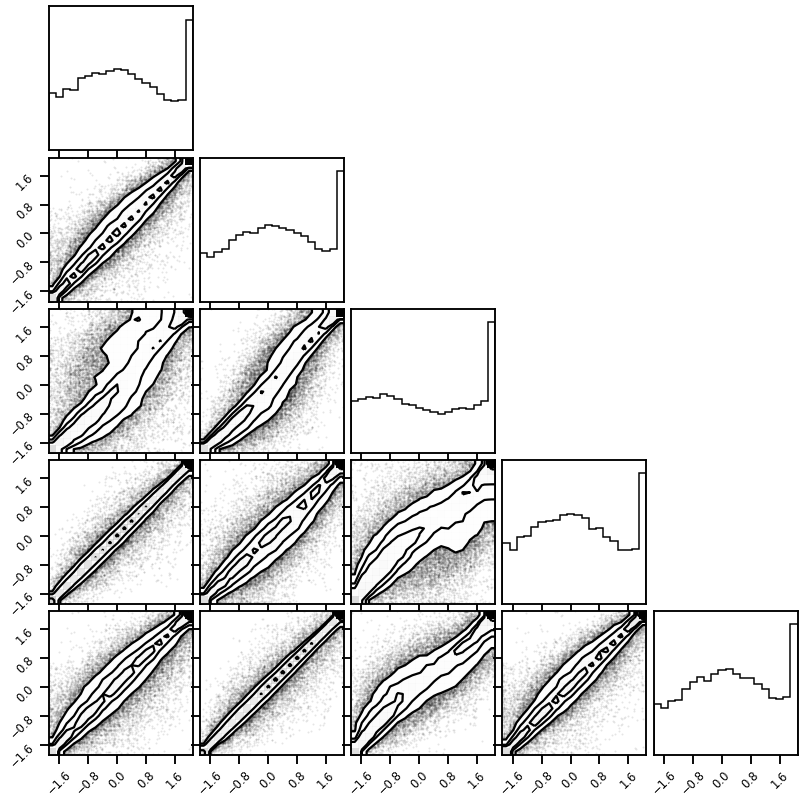

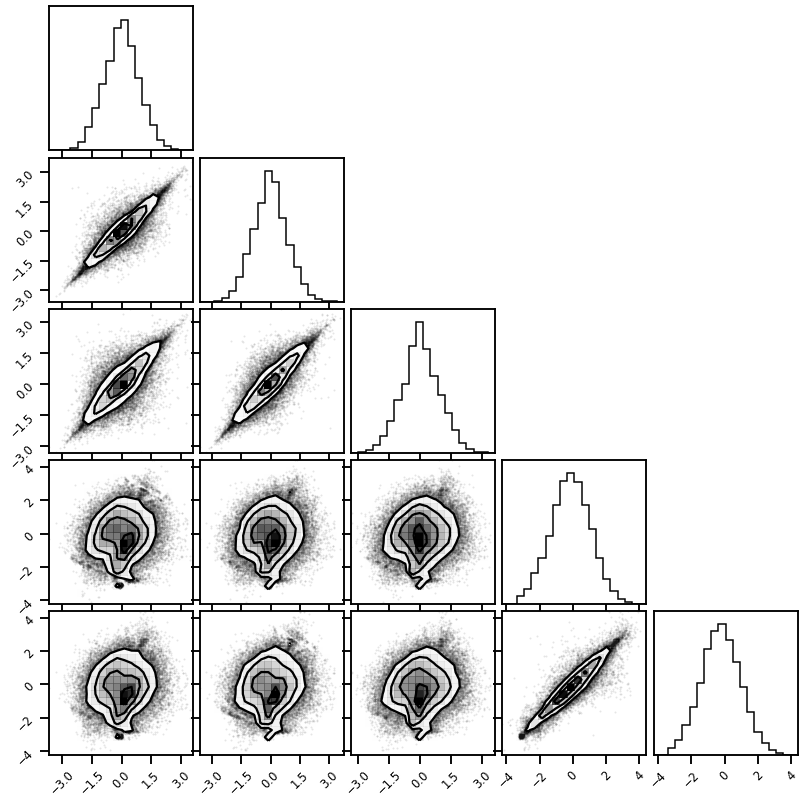

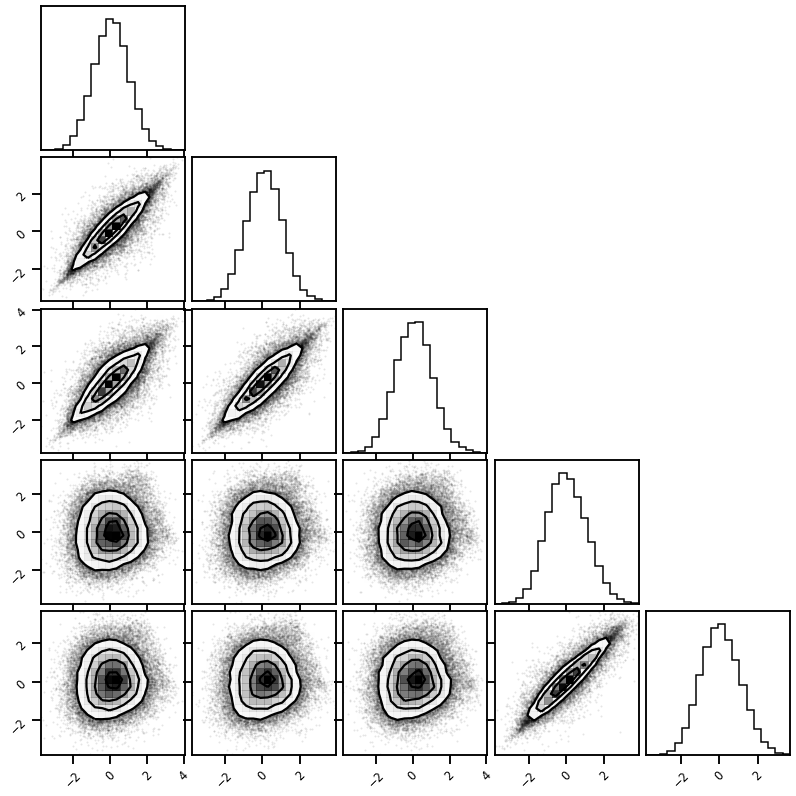

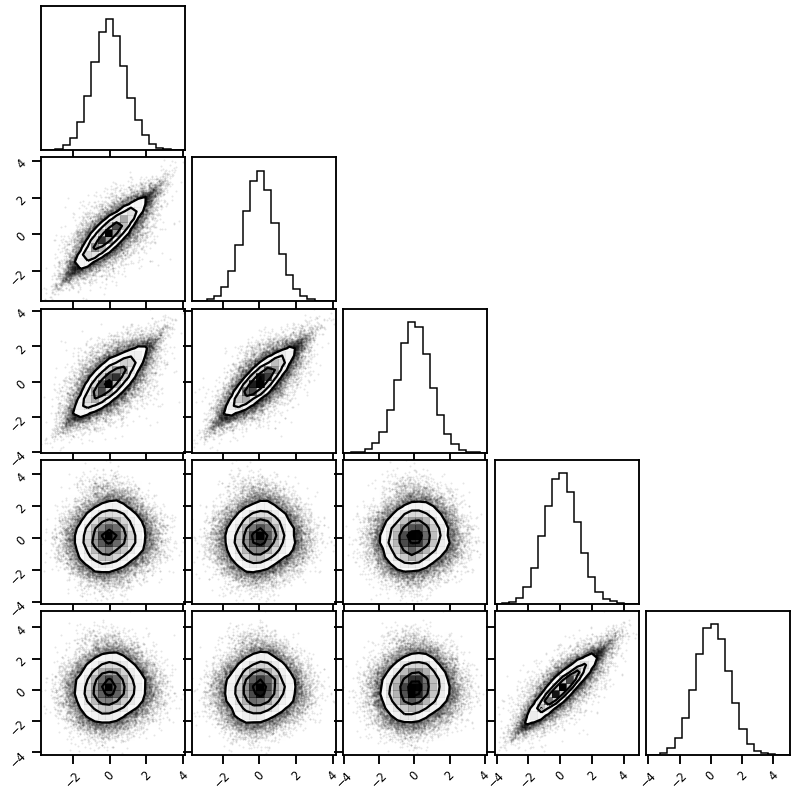

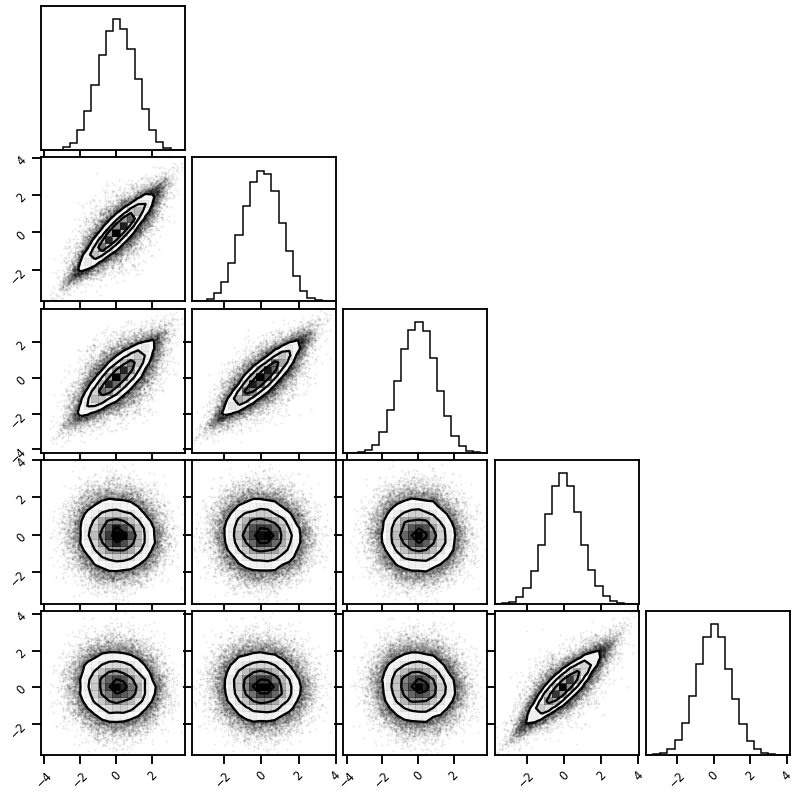

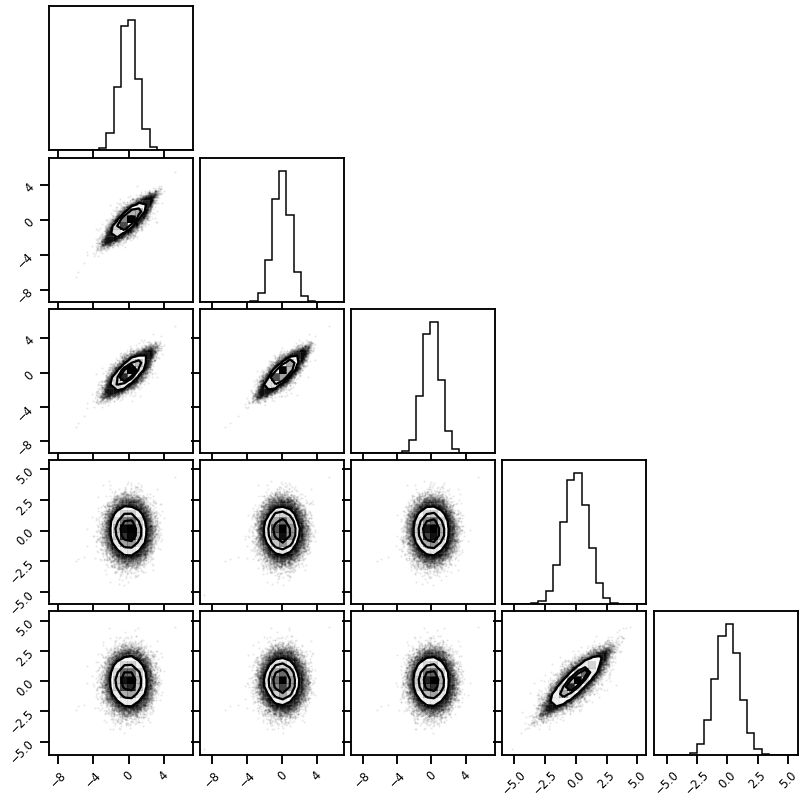

In [62]:
# layer params
filter_shapes = [(2, 2), (4, 4), (8, 8), (16, 16), (32, 32)]
n_layers = [10, 20, 30, 40, 50]
# n_layers = 100
params = []
losses = []
ilayer = 0
X_g = X
plot_layers = True

if plot_layers:
    fig = corner.corner(X_g.reshape((B, 32 * 32 * 3))[:, :5])

with tqdm.tqdm(list(zip(filter_shapes, n_layers))) as pbar:

    for i_mscale, (ifilter, i_layers) in enumerate(pbar):

        #         pbar.set_description(f"Multiscale Level: {i_mscale+1}, Filter: {ifilter}")

        # initialize layer
        reshape_layer = Squeeze(ifilter, "spatial")

        # initialize params and functions
        _, f, inv_f = reshape_layer((), X.shape)

        # save functions
        ms_params = {"reshape_f": f, "reshape_invf": inv_f}

        # transform data
        X_g, _ = f((), X_g)

        pbar.set_description(
            f"Multiscale Level: {i_mscale+1}, Filter: {ifilter}"
            f", Size: ({X_g.shape[0]:_},{X_g.shape[1]:_})"
        )

        # Gaussianize
        layer_params = []

        while ilayer < i_layers:

            # compute
            X_g, ilayer_params = fit_transform_func_jitted(X_g)

            # increment
            ilayer += 1

            layer_params.append(ilayer_params)

        ms_params["rbig_params"] = layer_params

        # save dictionary of params
        params.append(ms_params)

        # invert multiscale
        X_g, _ = inv_f((), X_g)
        if plot_layers:
            fig = corner.corner(X_g.reshape((B, 32 * 32 * 3))[:, :5])

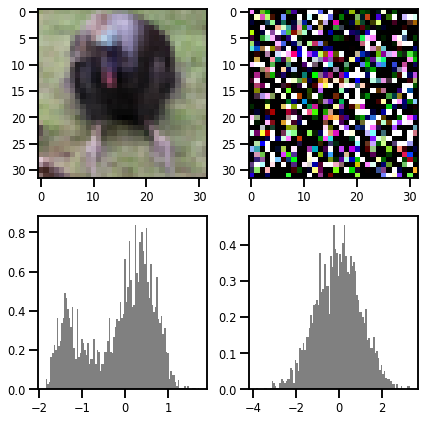

In [63]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
ax[0, 0].imshow(rescale_image(X[0], x_scaler))
ax[0, 1].imshow(X_g[0], cmap="gray")
ax[1, 0].hist(X[0].ravel(), bins=100, density=True, color="gray")
ax[1, 1].hist(X_g[0].ravel(), bins=100, density=True, color="gray")
plt.tight_layout()
plt.show()

### Inversion

1. Convert to Multiscale
2. Do Inverse Transformation
3. Invert to Original Scale
4. Repeat for all scales

In [64]:
X_approx = X_g

with tqdm.tqdm(params[::-1]) as pbar:

    for i_ms_layer, iparam in enumerate(pbar):

        # Convert to Multiscale transformation
        X_approx, _ = iparam["reshape_f"]((), X_approx)

        # Loop Through RBIG (in reverse)
        for i_layer_param in reversed(iparam["rbig_params"]):

            # inverse transformation
            X_approx = inverse_f_jitted(i_layer_param, X_approx)

        # Undo to Multiscale transformation
        X_approx, _ = iparam["reshape_invf"]((), X_approx)

100%|██████████| 5/5 [02:48<00:00, 33.71s/it]


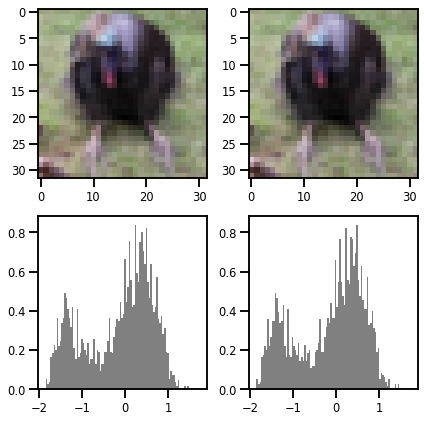

In [65]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
ax[0, 0].imshow(rescale_image(X_approx[0], x_scaler))
ax[0, 1].imshow(rescale_image(X[0], x_scaler))
ax[1, 0].hist(X[0].ravel(), bins=100, density=True, color="gray")
ax[1, 1].hist(X_approx[0].ravel(), bins=100, density=True, color="gray")
plt.tight_layout()
plt.show()

In [66]:
mse = jnp.mean((X_approx - X) ** 2)
print(f"MSE: {mse:.3e}")

MSE: 1.797e-04


<ipython-input-67-8a514dece863>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


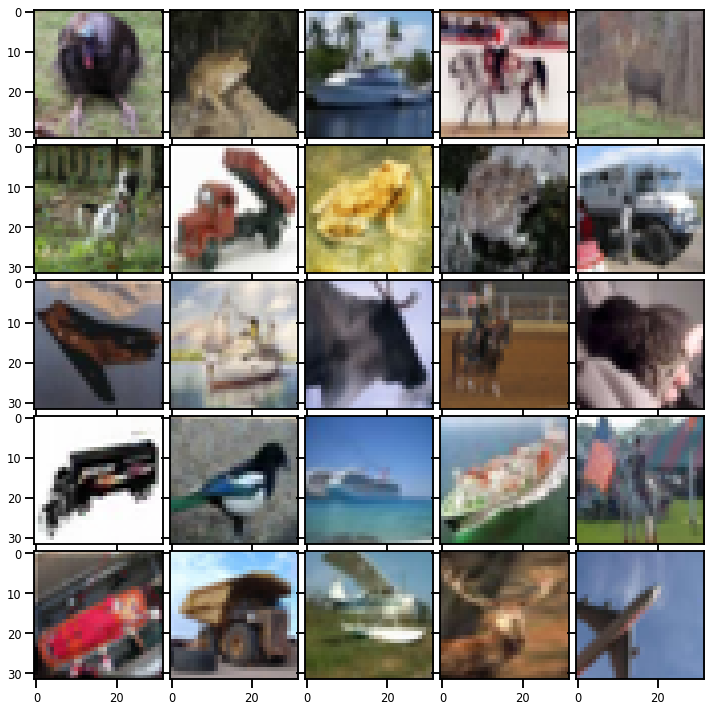

In [67]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10.0, 10.0))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(5, 5),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for i, ax in enumerate(grid):
    img = rescale_image(X_approx[i], x_scaler)
    ax.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

### Synthesis

In [68]:
rng = np.random.RandomState(123)

X_g_samples = rng.randn(*X_g.shape)

In [69]:
X_synth = X_g_samples

with tqdm.tqdm(params[::-1]) as pbar:

    for i_ms_layer, iparam in enumerate(pbar):

        # Convert to Multiscale transformation
        X_synth, _ = iparam["reshape_f"]((), X_synth)

        # Loop Through RBIG (in reverse)
        for i_layer_param in reversed(iparam["rbig_params"]):

            # inverse transformation
            X_synth = inverse_f_jitted(i_layer_param, X_synth)

        # Undo to Multiscale transformation
        X_synth, _ = iparam["reshape_invf"]((), X_synth)

100%|██████████| 5/5 [02:50<00:00, 34.19s/it]


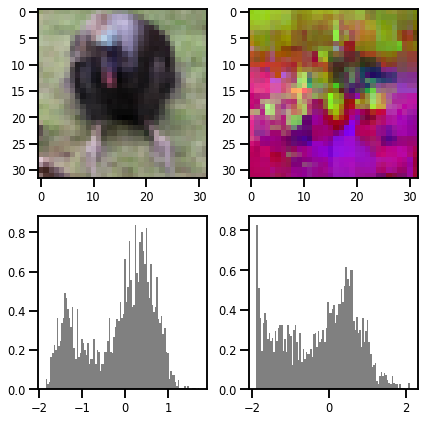

In [70]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
ax[0, 0].imshow(rescale_image(X[0], x_scaler))
ax[0, 1].imshow(rescale_image(X_synth[0], x_scaler))
ax[1, 0].hist(X[0].ravel(), bins=100, density=True, color="gray")
ax[1, 1].hist(X_synth[0].ravel(), bins=100, density=True, color="gray")
plt.tight_layout()
plt.show()

<ipython-input-71-bf44e34afe9c>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


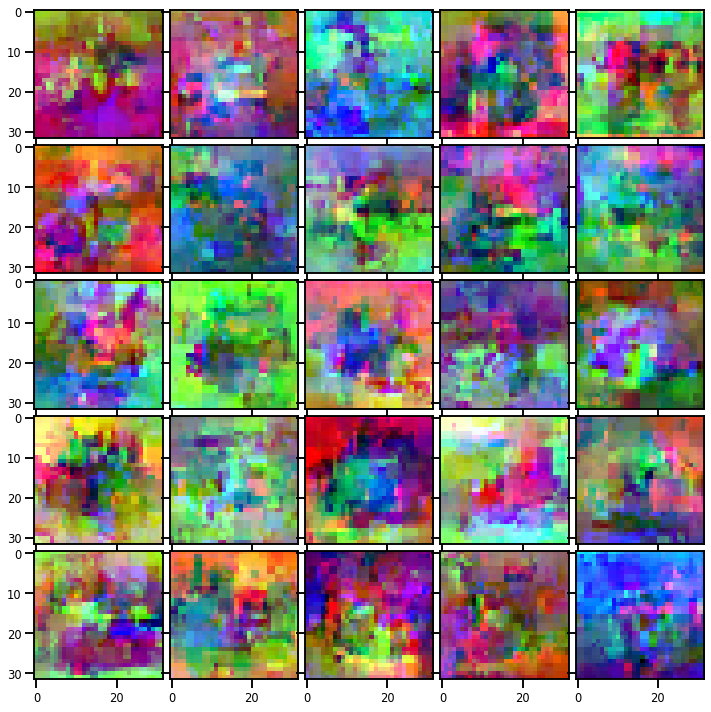

In [71]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10.0, 10.0))
grid = ImageGrid(
    fig,
    111,  # similar to subplot(111)
    nrows_ncols=(5, 5),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for i, ax in enumerate(grid):
    img = rescale_image(X_synth[i], x_scaler)
    ax.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()